# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [47]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

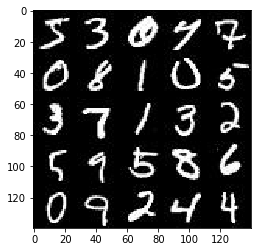

In [48]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

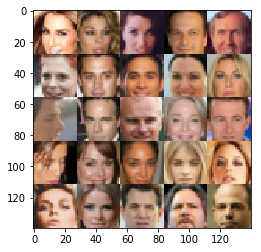

In [49]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels),name='real_inputs') 
    
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [54]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
              
        #Input Layer is 28x28x3,
        
        # Conv 1
        x1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=[5,5], strides=2, padding='SAME')
        #Depth of 64, Kernel size of 5x5, strides=2 this means the width and height of input is divided by 2
        #No batch normalization on this layer.
        leakyrelu1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        # Conv 2
        x2 = tf.layers.conv2d(inputs=leakyrelu1, filters=128, kernel_size=[5,5], strides=2, padding='SAME')
        #Output Depth of 128, Kernel size of 5x5
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        leakyrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #7x7x128
        
        # Conv 3
        x3 = tf.layers.conv2d(inputs=leakyrelu2, filters=256, kernel_size=[5,5], strides=1, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(x3, training=True)
        leakyrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        #7x7x256
        
        # Conv 4
        conv4 = tf.layers.conv2d(leakyrelu3, filters=512, kernel_size=[5,5], strides=1, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(conv4, training=True)
        leakyrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        #7x7x512
       
        # Flatten
        flat = tf.reshape(leakyrelu4, (-1, 7*7*512))
        
        # Logits
        logits = tf.layers.dense(flat, 1)
        
        # Output
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
    
    # Fully connected
        x2 = tf.layers.dense(z, 7*7*512)
        x2 = tf.reshape(x2, (-1, 7, 7, 512))
        x2 = tf.maximum(alpha*x2, x2)
        
        # Starting Conv Transpose Stack
        deconv2 = tf.layers.conv2d_transpose(inputs=x2, filters=256, kernel_size=[3,3], strides=1, padding='SAME')
        #Transposed convolution layer (sometimes called Deconvolution).
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        leakyrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        #7x7x256
        
        deconv3 = tf.layers.conv2d_transpose(inputs=leakyrelu2, filters=128, kernel_size=[3,3], strides=1, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        leakyrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        #7x7x128
        
        deconv4 = tf.layers.conv2d_transpose(inputs=leakyrelu3, filters=64, kernel_size=[3,3], strides=2, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        leakyrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        #14x14x64
        
        # Logits
        logits = tf.layers.conv2d_transpose(inputs=leakyrelu4, filters=out_channel_dim, kernel_size=[3,3],strides= 2, padding='SAME')
        #28x28xout_channel_dim
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [78]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #n_samples, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    samples, losses = [], []
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                
                steps += 1
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 2.8905... Generator Loss: 0.2706
Epoch 0/2... Discriminator Loss: 0.0725... Generator Loss: 4.2177
Epoch 0/2... Discriminator Loss: 0.0543... Generator Loss: 5.1398
Epoch 0/2... Discriminator Loss: 1.0533... Generator Loss: 8.7289
Epoch 0/2... Discriminator Loss: 4.0635... Generator Loss: 0.1837
Epoch 0/2... Discriminator Loss: 0.7103... Generator Loss: 2.5400
Epoch 0/2... Discriminator Loss: 3.0787... Generator Loss: 0.2751
Epoch 0/2... Discriminator Loss: 2.4598... Generator Loss: 5.0533
Epoch 0/2... Discriminator Loss: 2.1364... Generator Loss: 0.4463


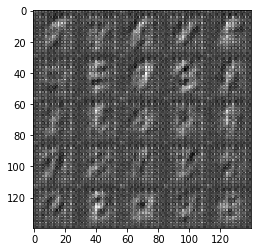

Epoch 0/2... Discriminator Loss: 4.2372... Generator Loss: 10.7226
Epoch 0/2... Discriminator Loss: 1.2264... Generator Loss: 6.1467
Epoch 0/2... Discriminator Loss: 1.1314... Generator Loss: 5.6186
Epoch 0/2... Discriminator Loss: 1.1812... Generator Loss: 0.7345
Epoch 0/2... Discriminator Loss: 0.5491... Generator Loss: 1.2650
Epoch 0/2... Discriminator Loss: 2.1465... Generator Loss: 0.2748
Epoch 0/2... Discriminator Loss: 0.3609... Generator Loss: 1.8195
Epoch 0/2... Discriminator Loss: 0.1790... Generator Loss: 2.6917
Epoch 0/2... Discriminator Loss: 0.2479... Generator Loss: 2.1566
Epoch 0/2... Discriminator Loss: 0.3770... Generator Loss: 2.8289


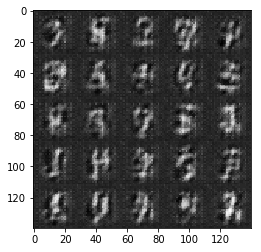

Epoch 0/2... Discriminator Loss: 0.3739... Generator Loss: 1.6997
Epoch 0/2... Discriminator Loss: 0.2331... Generator Loss: 2.2223
Epoch 0/2... Discriminator Loss: 0.9292... Generator Loss: 0.8849
Epoch 0/2... Discriminator Loss: 0.2205... Generator Loss: 2.3643
Epoch 0/2... Discriminator Loss: 0.2274... Generator Loss: 2.1767
Epoch 0/2... Discriminator Loss: 0.2926... Generator Loss: 4.3905
Epoch 0/2... Discriminator Loss: 0.2898... Generator Loss: 4.6391
Epoch 0/2... Discriminator Loss: 0.1560... Generator Loss: 2.3865
Epoch 0/2... Discriminator Loss: 8.6672... Generator Loss: 0.0007
Epoch 0/2... Discriminator Loss: 0.3261... Generator Loss: 2.3994


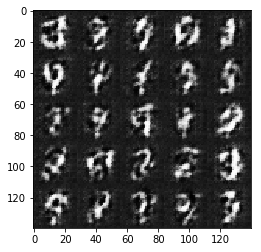

Epoch 0/2... Discriminator Loss: 0.2469... Generator Loss: 2.2475
Epoch 0/2... Discriminator Loss: 0.1773... Generator Loss: 2.9021
Epoch 0/2... Discriminator Loss: 0.1523... Generator Loss: 3.0180
Epoch 0/2... Discriminator Loss: 0.2542... Generator Loss: 1.9807
Epoch 0/2... Discriminator Loss: 0.2328... Generator Loss: 2.5542
Epoch 0/2... Discriminator Loss: 0.1286... Generator Loss: 3.1155
Epoch 0/2... Discriminator Loss: 0.1127... Generator Loss: 2.9766
Epoch 0/2... Discriminator Loss: 10.7099... Generator Loss: 17.9505
Epoch 0/2... Discriminator Loss: 1.5874... Generator Loss: 6.4670
Epoch 0/2... Discriminator Loss: 0.4615... Generator Loss: 3.1716


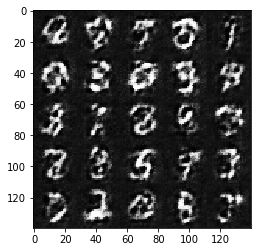

Epoch 0/2... Discriminator Loss: 0.2123... Generator Loss: 2.3983
Epoch 0/2... Discriminator Loss: 0.2134... Generator Loss: 2.9889
Epoch 0/2... Discriminator Loss: 0.3677... Generator Loss: 1.4942
Epoch 0/2... Discriminator Loss: 0.6285... Generator Loss: 5.0739
Epoch 0/2... Discriminator Loss: 0.3136... Generator Loss: 2.6652
Epoch 0/2... Discriminator Loss: 0.2446... Generator Loss: 2.5445
Epoch 0/2... Discriminator Loss: 0.1708... Generator Loss: 3.4587
Epoch 1/2... Discriminator Loss: 0.2916... Generator Loss: 1.8239
Epoch 1/2... Discriminator Loss: 0.2339... Generator Loss: 1.9983
Epoch 1/2... Discriminator Loss: 0.2967... Generator Loss: 1.8270


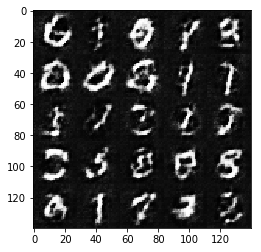

Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 0.1723... Generator Loss: 2.7198
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 1.2333
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 6.0204
Epoch 1/2... Discriminator Loss: 0.6667... Generator Loss: 2.8913
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 4.7520
Epoch 1/2... Discriminator Loss: 0.3108... Generator Loss: 3.2321
Epoch 1/2... Discriminator Loss: 0.5116... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 4.6765... Generator Loss: 8.1466
Epoch 1/2... Discriminator Loss: 2.1978... Generator Loss: 0.1719


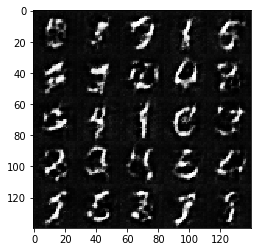

Epoch 1/2... Discriminator Loss: 0.2618... Generator Loss: 2.1278
Epoch 1/2... Discriminator Loss: 0.3000... Generator Loss: 1.7687
Epoch 1/2... Discriminator Loss: 0.3060... Generator Loss: 1.7676
Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 1.5746
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 1.0574
Epoch 1/2... Discriminator Loss: 0.4119... Generator Loss: 1.5663
Epoch 1/2... Discriminator Loss: 1.4267... Generator Loss: 0.3898
Epoch 1/2... Discriminator Loss: 1.6044... Generator Loss: 3.1541
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 3.0850
Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 1.7138


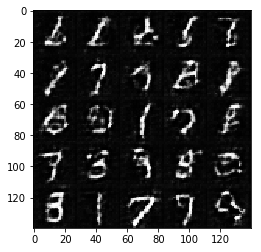

Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 2.0284
Epoch 1/2... Discriminator Loss: 0.7186... Generator Loss: 1.2892
Epoch 1/2... Discriminator Loss: 0.3795... Generator Loss: 1.7634
Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.0304
Epoch 1/2... Discriminator Loss: 0.3911... Generator Loss: 1.5010
Epoch 1/2... Discriminator Loss: 0.4573... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 0.5809... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 0.6448... Generator Loss: 0.9940


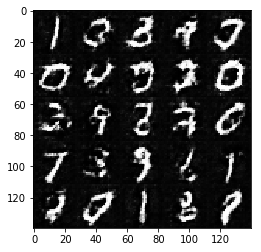

Epoch 1/2... Discriminator Loss: 2.2015... Generator Loss: 6.7354
Epoch 1/2... Discriminator Loss: 2.0417... Generator Loss: 0.2455
Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 3.8523
Epoch 1/2... Discriminator Loss: 0.6217... Generator Loss: 1.5583
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 2.0767
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.4841
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 0.6151
Epoch 1/2... Discriminator Loss: 0.8075... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 1.1082
Epoch 1/2... Discriminator Loss: 0.5768... Generator Loss: 2.9322


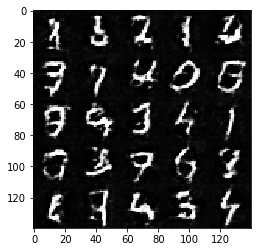

Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 2.0963
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 2.1243
Epoch 1/2... Discriminator Loss: 2.3680... Generator Loss: 4.0046
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.4906


In [79]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 3.0191... Generator Loss: 0.2069
Epoch 0/1... Discriminator Loss: 0.0003... Generator Loss: 10.4759
Epoch 0/1... Discriminator Loss: 0.3914... Generator Loss: 12.2138
Epoch 0/1... Discriminator Loss: 1.8138... Generator Loss: 0.7000
Epoch 0/1... Discriminator Loss: 0.4489... Generator Loss: 6.2608
Epoch 0/1... Discriminator Loss: 0.0440... Generator Loss: 7.5542
Epoch 0/1... Discriminator Loss: 0.2616... Generator Loss: 4.9313
Epoch 0/1... Discriminator Loss: 6.5900... Generator Loss: 15.2091
Epoch 0/1... Discriminator Loss: 0.5280... Generator Loss: 3.7590


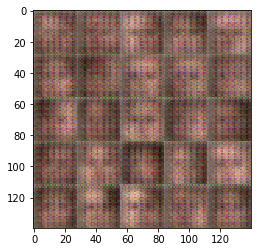

Epoch 0/1... Discriminator Loss: 1.0601... Generator Loss: 6.6826
Epoch 0/1... Discriminator Loss: 3.9618... Generator Loss: 0.0449
Epoch 0/1... Discriminator Loss: 1.6702... Generator Loss: 5.1516
Epoch 0/1... Discriminator Loss: 1.3940... Generator Loss: 0.4721
Epoch 0/1... Discriminator Loss: 0.4908... Generator Loss: 1.8088
Epoch 0/1... Discriminator Loss: 0.4134... Generator Loss: 4.2227
Epoch 0/1... Discriminator Loss: 0.8584... Generator Loss: 0.9490
Epoch 0/1... Discriminator Loss: 0.6143... Generator Loss: 2.2174
Epoch 0/1... Discriminator Loss: 1.0086... Generator Loss: 0.9657
Epoch 0/1... Discriminator Loss: 0.8498... Generator Loss: 1.8490


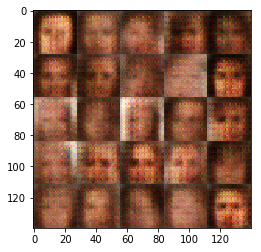

Epoch 0/1... Discriminator Loss: 1.1144... Generator Loss: 0.7963
Epoch 0/1... Discriminator Loss: 0.4553... Generator Loss: 2.1526
Epoch 0/1... Discriminator Loss: 0.9492... Generator Loss: 1.1162
Epoch 0/1... Discriminator Loss: 1.0979... Generator Loss: 0.7845
Epoch 0/1... Discriminator Loss: 3.3143... Generator Loss: 0.0870
Epoch 0/1... Discriminator Loss: 1.4572... Generator Loss: 0.5326
Epoch 0/1... Discriminator Loss: 1.3397... Generator Loss: 2.6021
Epoch 0/1... Discriminator Loss: 0.8890... Generator Loss: 0.9033
Epoch 0/1... Discriminator Loss: 0.7668... Generator Loss: 1.3212
Epoch 0/1... Discriminator Loss: 1.6427... Generator Loss: 0.3346


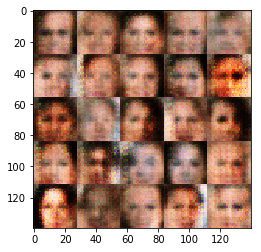

Epoch 0/1... Discriminator Loss: 0.9288... Generator Loss: 0.9009
Epoch 0/1... Discriminator Loss: 0.7286... Generator Loss: 1.3844
Epoch 0/1... Discriminator Loss: 1.7937... Generator Loss: 0.3635
Epoch 0/1... Discriminator Loss: 1.6941... Generator Loss: 0.4379
Epoch 0/1... Discriminator Loss: 0.8519... Generator Loss: 1.2855
Epoch 0/1... Discriminator Loss: 1.9383... Generator Loss: 0.3387
Epoch 0/1... Discriminator Loss: 1.4117... Generator Loss: 3.7173
Epoch 0/1... Discriminator Loss: 0.8038... Generator Loss: 3.3238
Epoch 0/1... Discriminator Loss: 1.1050... Generator Loss: 2.6526
Epoch 0/1... Discriminator Loss: 2.6011... Generator Loss: 0.1464


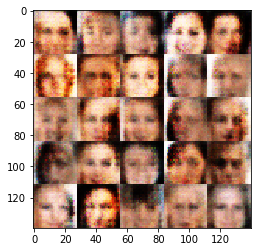

Epoch 0/1... Discriminator Loss: 0.8442... Generator Loss: 1.4012
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 1.6852
Epoch 0/1... Discriminator Loss: 1.1975... Generator Loss: 0.6864
Epoch 0/1... Discriminator Loss: 1.3902... Generator Loss: 0.5130
Epoch 0/1... Discriminator Loss: 1.3208... Generator Loss: 0.5258
Epoch 0/1... Discriminator Loss: 0.9644... Generator Loss: 2.6424
Epoch 0/1... Discriminator Loss: 0.7729... Generator Loss: 1.2566
Epoch 0/1... Discriminator Loss: 1.3761... Generator Loss: 0.4556
Epoch 0/1... Discriminator Loss: 0.8044... Generator Loss: 0.9191
Epoch 0/1... Discriminator Loss: 0.7495... Generator Loss: 0.9107


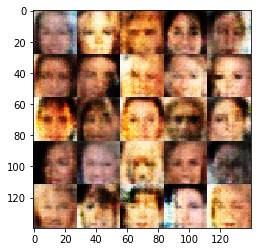

Epoch 0/1... Discriminator Loss: 1.1865... Generator Loss: 0.5589
Epoch 0/1... Discriminator Loss: 0.7306... Generator Loss: 1.1722
Epoch 0/1... Discriminator Loss: 0.9190... Generator Loss: 1.3790
Epoch 0/1... Discriminator Loss: 0.8735... Generator Loss: 0.9608
Epoch 0/1... Discriminator Loss: 2.1128... Generator Loss: 3.1088
Epoch 0/1... Discriminator Loss: 0.7254... Generator Loss: 1.4152
Epoch 0/1... Discriminator Loss: 0.9168... Generator Loss: 0.8177
Epoch 0/1... Discriminator Loss: 1.3255... Generator Loss: 0.4507
Epoch 0/1... Discriminator Loss: 2.3243... Generator Loss: 0.1750
Epoch 0/1... Discriminator Loss: 1.3334... Generator Loss: 0.5351


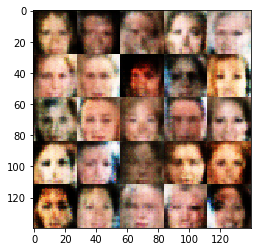

Epoch 0/1... Discriminator Loss: 0.8447... Generator Loss: 1.6042
Epoch 0/1... Discriminator Loss: 2.3582... Generator Loss: 3.9334
Epoch 0/1... Discriminator Loss: 0.9182... Generator Loss: 1.2953
Epoch 0/1... Discriminator Loss: 2.8163... Generator Loss: 5.4407
Epoch 0/1... Discriminator Loss: 1.1131... Generator Loss: 1.1902
Epoch 0/1... Discriminator Loss: 0.6796... Generator Loss: 1.4941
Epoch 0/1... Discriminator Loss: 1.1262... Generator Loss: 0.5823
Epoch 0/1... Discriminator Loss: 1.6534... Generator Loss: 3.4566
Epoch 0/1... Discriminator Loss: 0.9297... Generator Loss: 1.6488
Epoch 0/1... Discriminator Loss: 0.6742... Generator Loss: 1.3131


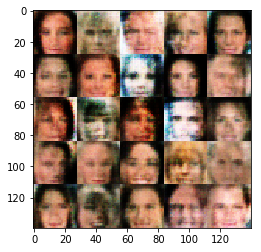

Epoch 0/1... Discriminator Loss: 0.8578... Generator Loss: 1.2777
Epoch 0/1... Discriminator Loss: 1.7124... Generator Loss: 0.3018
Epoch 0/1... Discriminator Loss: 0.7198... Generator Loss: 1.1049
Epoch 0/1... Discriminator Loss: 0.8384... Generator Loss: 0.9457
Epoch 0/1... Discriminator Loss: 1.0025... Generator Loss: 1.9980
Epoch 0/1... Discriminator Loss: 0.8191... Generator Loss: 1.5699
Epoch 0/1... Discriminator Loss: 1.1338... Generator Loss: 0.6087
Epoch 0/1... Discriminator Loss: 0.8055... Generator Loss: 2.0467
Epoch 0/1... Discriminator Loss: 1.9833... Generator Loss: 0.2002
Epoch 0/1... Discriminator Loss: 1.3340... Generator Loss: 0.4555


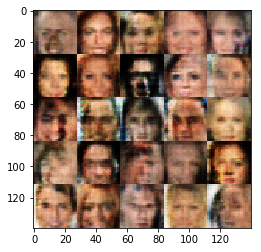

Epoch 0/1... Discriminator Loss: 0.9442... Generator Loss: 0.8880
Epoch 0/1... Discriminator Loss: 0.9147... Generator Loss: 0.9217
Epoch 0/1... Discriminator Loss: 0.9679... Generator Loss: 0.7387
Epoch 0/1... Discriminator Loss: 1.6411... Generator Loss: 0.3095
Epoch 0/1... Discriminator Loss: 1.8278... Generator Loss: 0.2708
Epoch 0/1... Discriminator Loss: 0.9889... Generator Loss: 0.8320
Epoch 0/1... Discriminator Loss: 1.3910... Generator Loss: 3.0508
Epoch 0/1... Discriminator Loss: 1.4267... Generator Loss: 4.0691
Epoch 0/1... Discriminator Loss: 0.9100... Generator Loss: 0.7400
Epoch 0/1... Discriminator Loss: 1.3232... Generator Loss: 0.4284


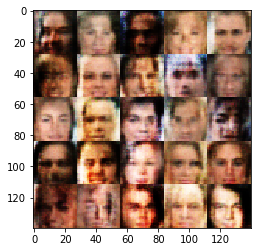

Epoch 0/1... Discriminator Loss: 1.0696... Generator Loss: 0.7556
Epoch 0/1... Discriminator Loss: 0.9439... Generator Loss: 0.7681
Epoch 0/1... Discriminator Loss: 1.8023... Generator Loss: 0.2610
Epoch 0/1... Discriminator Loss: 0.5538... Generator Loss: 1.6551
Epoch 0/1... Discriminator Loss: 0.5578... Generator Loss: 1.5329
Epoch 0/1... Discriminator Loss: 0.9625... Generator Loss: 0.7029
Epoch 0/1... Discriminator Loss: 0.7512... Generator Loss: 1.9734
Epoch 0/1... Discriminator Loss: 1.6652... Generator Loss: 0.4129
Epoch 0/1... Discriminator Loss: 0.5288... Generator Loss: 1.5172
Epoch 0/1... Discriminator Loss: 1.4299... Generator Loss: 0.4049


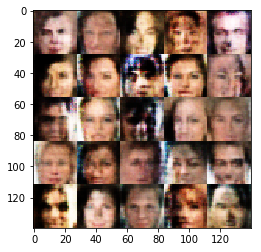

Epoch 0/1... Discriminator Loss: 1.5229... Generator Loss: 0.3713
Epoch 0/1... Discriminator Loss: 0.4827... Generator Loss: 2.3276
Epoch 0/1... Discriminator Loss: 1.2684... Generator Loss: 0.4219
Epoch 0/1... Discriminator Loss: 0.9730... Generator Loss: 0.6708
Epoch 0/1... Discriminator Loss: 1.3931... Generator Loss: 0.4432
Epoch 0/1... Discriminator Loss: 1.4611... Generator Loss: 0.3693
Epoch 0/1... Discriminator Loss: 0.5679... Generator Loss: 1.4174
Epoch 0/1... Discriminator Loss: 0.8261... Generator Loss: 1.9528
Epoch 0/1... Discriminator Loss: 1.6253... Generator Loss: 0.3360
Epoch 0/1... Discriminator Loss: 1.1484... Generator Loss: 0.5445


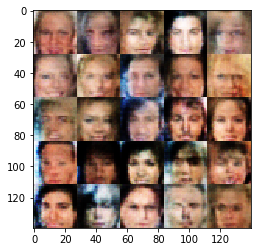

Epoch 0/1... Discriminator Loss: 0.8700... Generator Loss: 0.9144
Epoch 0/1... Discriminator Loss: 0.9821... Generator Loss: 2.5083
Epoch 0/1... Discriminator Loss: 1.1047... Generator Loss: 0.5861
Epoch 0/1... Discriminator Loss: 2.0913... Generator Loss: 0.2309
Epoch 0/1... Discriminator Loss: 1.0632... Generator Loss: 0.5437
Epoch 0/1... Discriminator Loss: 0.3907... Generator Loss: 2.0559
Epoch 0/1... Discriminator Loss: 2.2449... Generator Loss: 5.5724
Epoch 0/1... Discriminator Loss: 0.5075... Generator Loss: 1.8104
Epoch 0/1... Discriminator Loss: 0.6756... Generator Loss: 1.4888
Epoch 0/1... Discriminator Loss: 1.0327... Generator Loss: 4.1770


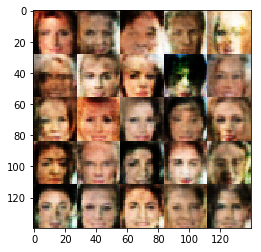

Epoch 0/1... Discriminator Loss: 0.5126... Generator Loss: 2.1849
Epoch 0/1... Discriminator Loss: 0.7793... Generator Loss: 0.8192
Epoch 0/1... Discriminator Loss: 1.9086... Generator Loss: 0.2321
Epoch 0/1... Discriminator Loss: 0.8253... Generator Loss: 0.9652
Epoch 0/1... Discriminator Loss: 0.6591... Generator Loss: 3.3091
Epoch 0/1... Discriminator Loss: 1.4505... Generator Loss: 0.4245
Epoch 0/1... Discriminator Loss: 0.8070... Generator Loss: 1.2537
Epoch 0/1... Discriminator Loss: 1.4184... Generator Loss: 4.0258
Epoch 0/1... Discriminator Loss: 0.3183... Generator Loss: 3.3246
Epoch 0/1... Discriminator Loss: 1.1774... Generator Loss: 0.5254


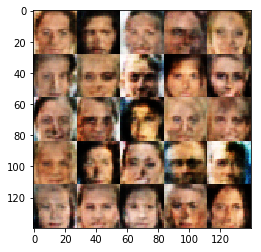

Epoch 0/1... Discriminator Loss: 0.6283... Generator Loss: 1.1127
Epoch 0/1... Discriminator Loss: 0.3141... Generator Loss: 1.7500
Epoch 0/1... Discriminator Loss: 2.9673... Generator Loss: 0.1524
Epoch 0/1... Discriminator Loss: 0.7619... Generator Loss: 2.9497
Epoch 0/1... Discriminator Loss: 0.4263... Generator Loss: 2.3968
Epoch 0/1... Discriminator Loss: 0.3901... Generator Loss: 1.9329
Epoch 0/1... Discriminator Loss: 0.4325... Generator Loss: 3.2867
Epoch 0/1... Discriminator Loss: 0.7900... Generator Loss: 2.3068
Epoch 0/1... Discriminator Loss: 0.2006... Generator Loss: 2.7701
Epoch 0/1... Discriminator Loss: 0.3117... Generator Loss: 1.9286


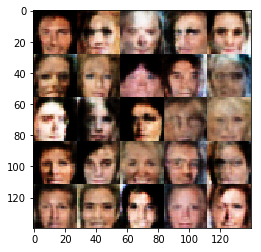

Epoch 0/1... Discriminator Loss: 0.2949... Generator Loss: 5.3782
Epoch 0/1... Discriminator Loss: 0.0770... Generator Loss: 3.8439
Epoch 0/1... Discriminator Loss: 2.4567... Generator Loss: 2.4517
Epoch 0/1... Discriminator Loss: 1.1920... Generator Loss: 0.6486
Epoch 0/1... Discriminator Loss: 0.5666... Generator Loss: 3.2243
Epoch 0/1... Discriminator Loss: 0.5364... Generator Loss: 1.2077
Epoch 0/1... Discriminator Loss: 0.8109... Generator Loss: 5.1920
Epoch 0/1... Discriminator Loss: 0.2137... Generator Loss: 2.5845
Epoch 0/1... Discriminator Loss: 3.0412... Generator Loss: 0.1168
Epoch 0/1... Discriminator Loss: 0.8588... Generator Loss: 1.3432


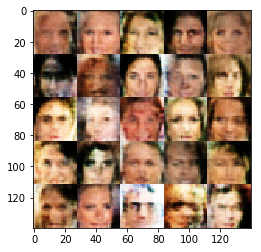

Epoch 0/1... Discriminator Loss: 1.9485... Generator Loss: 0.2909
Epoch 0/1... Discriminator Loss: 0.8533... Generator Loss: 1.0888
Epoch 0/1... Discriminator Loss: 0.8504... Generator Loss: 1.0003
Epoch 0/1... Discriminator Loss: 0.3955... Generator Loss: 1.6174
Epoch 0/1... Discriminator Loss: 0.2374... Generator Loss: 3.8966
Epoch 0/1... Discriminator Loss: 0.6236... Generator Loss: 1.1020
Epoch 0/1... Discriminator Loss: 0.4180... Generator Loss: 2.0733
Epoch 0/1... Discriminator Loss: 2.7039... Generator Loss: 0.2008
Epoch 0/1... Discriminator Loss: 1.6702... Generator Loss: 0.4599
Epoch 0/1... Discriminator Loss: 1.0456... Generator Loss: 0.8998


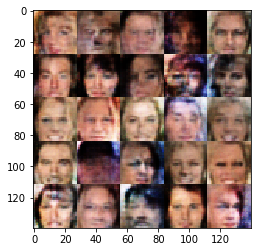

Epoch 0/1... Discriminator Loss: 0.5986... Generator Loss: 1.5925
Epoch 0/1... Discriminator Loss: 0.6652... Generator Loss: 1.0064
Epoch 0/1... Discriminator Loss: 0.6753... Generator Loss: 2.6805
Epoch 0/1... Discriminator Loss: 0.5938... Generator Loss: 2.2112
Epoch 0/1... Discriminator Loss: 0.1925... Generator Loss: 3.1422
Epoch 0/1... Discriminator Loss: 0.4824... Generator Loss: 1.4258
Epoch 0/1... Discriminator Loss: 0.3642... Generator Loss: 2.0226
Epoch 0/1... Discriminator Loss: 0.3292... Generator Loss: 3.5662
Epoch 0/1... Discriminator Loss: 0.1059... Generator Loss: 2.7779
Epoch 0/1... Discriminator Loss: 0.5135... Generator Loss: 2.0148


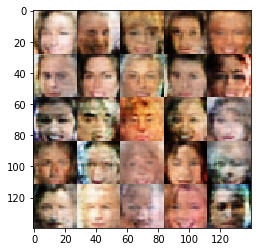

Epoch 0/1... Discriminator Loss: 0.9700... Generator Loss: 4.3361
Epoch 0/1... Discriminator Loss: 0.2636... Generator Loss: 2.6495
Epoch 0/1... Discriminator Loss: 0.4255... Generator Loss: 5.2434
Epoch 0/1... Discriminator Loss: 0.6855... Generator Loss: 3.3029
Epoch 0/1... Discriminator Loss: 0.2023... Generator Loss: 2.8741
Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 3.7020
Epoch 0/1... Discriminator Loss: 1.0992... Generator Loss: 0.6478
Epoch 0/1... Discriminator Loss: 0.5393... Generator Loss: 1.4713
Epoch 0/1... Discriminator Loss: 0.7231... Generator Loss: 1.0357
Epoch 0/1... Discriminator Loss: 0.5541... Generator Loss: 1.2626


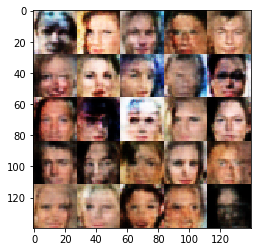

Epoch 0/1... Discriminator Loss: 0.3919... Generator Loss: 2.3622
Epoch 0/1... Discriminator Loss: 0.3457... Generator Loss: 4.0627
Epoch 0/1... Discriminator Loss: 0.1134... Generator Loss: 3.4607
Epoch 0/1... Discriminator Loss: 0.3582... Generator Loss: 4.2439
Epoch 0/1... Discriminator Loss: 0.1549... Generator Loss: 2.3751
Epoch 0/1... Discriminator Loss: 0.2063... Generator Loss: 6.8106
Epoch 0/1... Discriminator Loss: 1.9313... Generator Loss: 0.3568
Epoch 0/1... Discriminator Loss: 1.2560... Generator Loss: 0.5613
Epoch 0/1... Discriminator Loss: 0.2095... Generator Loss: 2.6056
Epoch 0/1... Discriminator Loss: 0.6304... Generator Loss: 1.2056


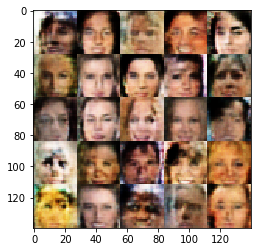

Epoch 0/1... Discriminator Loss: 0.9394... Generator Loss: 0.8090
Epoch 0/1... Discriminator Loss: 0.6122... Generator Loss: 1.3493
Epoch 0/1... Discriminator Loss: 0.3139... Generator Loss: 1.9104
Epoch 0/1... Discriminator Loss: 0.3688... Generator Loss: 1.5805
Epoch 0/1... Discriminator Loss: 0.0991... Generator Loss: 3.8846
Epoch 0/1... Discriminator Loss: 0.4692... Generator Loss: 1.4555
Epoch 0/1... Discriminator Loss: 0.6435... Generator Loss: 1.2263
Epoch 0/1... Discriminator Loss: 0.7179... Generator Loss: 0.9041
Epoch 0/1... Discriminator Loss: 0.3197... Generator Loss: 2.2058
Epoch 0/1... Discriminator Loss: 0.5244... Generator Loss: 4.2551


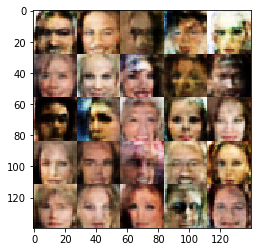

Epoch 0/1... Discriminator Loss: 0.2162... Generator Loss: 2.8566
Epoch 0/1... Discriminator Loss: 2.1839... Generator Loss: 0.2691
Epoch 0/1... Discriminator Loss: 0.1825... Generator Loss: 2.6414
Epoch 0/1... Discriminator Loss: 1.2028... Generator Loss: 0.7198
Epoch 0/1... Discriminator Loss: 0.2443... Generator Loss: 2.1496
Epoch 0/1... Discriminator Loss: 0.8463... Generator Loss: 0.8231
Epoch 0/1... Discriminator Loss: 0.3435... Generator Loss: 1.6873
Epoch 0/1... Discriminator Loss: 0.1100... Generator Loss: 3.3964
Epoch 0/1... Discriminator Loss: 0.5768... Generator Loss: 1.3272
Epoch 0/1... Discriminator Loss: 0.4696... Generator Loss: 1.4298


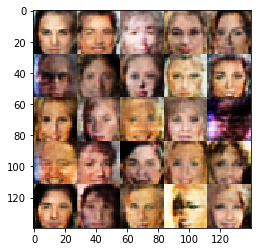

Epoch 0/1... Discriminator Loss: 0.3009... Generator Loss: 2.0233
Epoch 0/1... Discriminator Loss: 0.1286... Generator Loss: 2.5838
Epoch 0/1... Discriminator Loss: 0.3169... Generator Loss: 3.2181
Epoch 0/1... Discriminator Loss: 0.7416... Generator Loss: 0.9908
Epoch 0/1... Discriminator Loss: 1.3902... Generator Loss: 0.5601
Epoch 0/1... Discriminator Loss: 1.3787... Generator Loss: 0.5024
Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.6131
Epoch 0/1... Discriminator Loss: 0.4726... Generator Loss: 2.6115
Epoch 0/1... Discriminator Loss: 0.3167... Generator Loss: 2.0689
Epoch 0/1... Discriminator Loss: 2.9385... Generator Loss: 0.1130


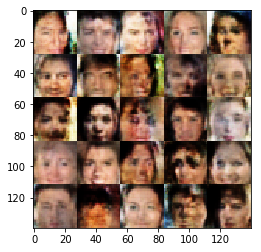

Epoch 0/1... Discriminator Loss: 1.2714... Generator Loss: 0.6760
Epoch 0/1... Discriminator Loss: 0.5606... Generator Loss: 1.1682
Epoch 0/1... Discriminator Loss: 0.8519... Generator Loss: 0.8476
Epoch 0/1... Discriminator Loss: 1.5082... Generator Loss: 0.5761
Epoch 0/1... Discriminator Loss: 0.6480... Generator Loss: 1.1984
Epoch 0/1... Discriminator Loss: 0.6715... Generator Loss: 1.1805
Epoch 0/1... Discriminator Loss: 0.3909... Generator Loss: 1.9410
Epoch 0/1... Discriminator Loss: 0.7953... Generator Loss: 0.8545
Epoch 0/1... Discriminator Loss: 0.4605... Generator Loss: 3.7376
Epoch 0/1... Discriminator Loss: 0.0659... Generator Loss: 4.3099


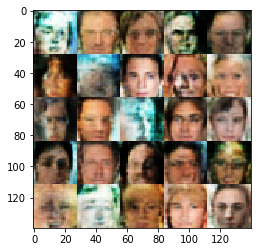

Epoch 0/1... Discriminator Loss: 0.2527... Generator Loss: 2.9470
Epoch 0/1... Discriminator Loss: 0.5678... Generator Loss: 1.1397
Epoch 0/1... Discriminator Loss: 0.7446... Generator Loss: 0.8876
Epoch 0/1... Discriminator Loss: 0.2923... Generator Loss: 2.1652
Epoch 0/1... Discriminator Loss: 0.2669... Generator Loss: 2.1396
Epoch 0/1... Discriminator Loss: 0.1893... Generator Loss: 2.3571
Epoch 0/1... Discriminator Loss: 0.1967... Generator Loss: 3.4922
Epoch 0/1... Discriminator Loss: 0.1212... Generator Loss: 2.8919
Epoch 0/1... Discriminator Loss: 1.1447... Generator Loss: 0.7698
Epoch 0/1... Discriminator Loss: 1.5757... Generator Loss: 0.4214


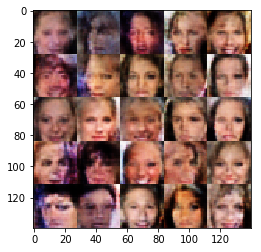

Epoch 0/1... Discriminator Loss: 0.2595... Generator Loss: 2.5117
Epoch 0/1... Discriminator Loss: 0.7703... Generator Loss: 6.5593
Epoch 0/1... Discriminator Loss: 2.8505... Generator Loss: 0.1825
Epoch 0/1... Discriminator Loss: 0.4571... Generator Loss: 2.9065
Epoch 0/1... Discriminator Loss: 1.2778... Generator Loss: 4.9500
Epoch 0/1... Discriminator Loss: 1.7590... Generator Loss: 0.4679
Epoch 0/1... Discriminator Loss: 0.7034... Generator Loss: 0.9372
Epoch 0/1... Discriminator Loss: 0.1620... Generator Loss: 2.6705
Epoch 0/1... Discriminator Loss: 0.1527... Generator Loss: 2.8264
Epoch 0/1... Discriminator Loss: 0.0411... Generator Loss: 4.4496


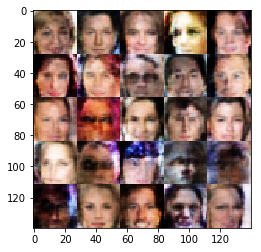

Epoch 0/1... Discriminator Loss: 0.4069... Generator Loss: 1.6561
Epoch 0/1... Discriminator Loss: 0.4253... Generator Loss: 1.6305
Epoch 0/1... Discriminator Loss: 0.3477... Generator Loss: 2.0711
Epoch 0/1... Discriminator Loss: 0.2219... Generator Loss: 2.4501
Epoch 0/1... Discriminator Loss: 0.1708... Generator Loss: 2.5494
Epoch 0/1... Discriminator Loss: 0.0705... Generator Loss: 4.7972
Epoch 0/1... Discriminator Loss: 2.1372... Generator Loss: 0.3054
Epoch 0/1... Discriminator Loss: 1.9476... Generator Loss: 0.3301
Epoch 0/1... Discriminator Loss: 0.6686... Generator Loss: 1.4981
Epoch 0/1... Discriminator Loss: 1.6215... Generator Loss: 0.4843


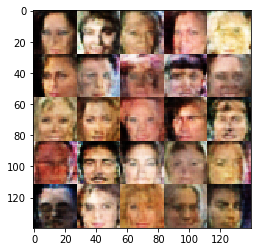

Epoch 0/1... Discriminator Loss: 2.3400... Generator Loss: 0.1986
Epoch 0/1... Discriminator Loss: 0.4134... Generator Loss: 3.0226
Epoch 0/1... Discriminator Loss: 0.2212... Generator Loss: 2.6945
Epoch 0/1... Discriminator Loss: 0.7092... Generator Loss: 0.8985
Epoch 0/1... Discriminator Loss: 1.3254... Generator Loss: 5.0166
Epoch 0/1... Discriminator Loss: 0.4430... Generator Loss: 1.4986
Epoch 0/1... Discriminator Loss: 0.1790... Generator Loss: 4.0230
Epoch 0/1... Discriminator Loss: 0.5695... Generator Loss: 1.2175
Epoch 0/1... Discriminator Loss: 0.1336... Generator Loss: 3.1092
Epoch 0/1... Discriminator Loss: 0.1447... Generator Loss: 2.9045


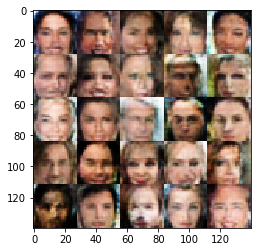

Epoch 0/1... Discriminator Loss: 0.4894... Generator Loss: 1.3540
Epoch 0/1... Discriminator Loss: 0.1924... Generator Loss: 2.3372
Epoch 0/1... Discriminator Loss: 0.1642... Generator Loss: 2.7015
Epoch 0/1... Discriminator Loss: 0.9224... Generator Loss: 1.5313
Epoch 0/1... Discriminator Loss: 0.7382... Generator Loss: 1.0453
Epoch 0/1... Discriminator Loss: 1.0427... Generator Loss: 0.7738
Epoch 0/1... Discriminator Loss: 0.4150... Generator Loss: 3.4332
Epoch 0/1... Discriminator Loss: 0.3957... Generator Loss: 3.7085
Epoch 0/1... Discriminator Loss: 1.0627... Generator Loss: 0.6847
Epoch 0/1... Discriminator Loss: 1.7087... Generator Loss: 0.4288


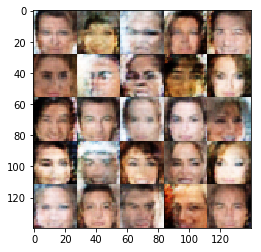

Epoch 0/1... Discriminator Loss: 0.3710... Generator Loss: 2.9290
Epoch 0/1... Discriminator Loss: 1.5636... Generator Loss: 0.3392
Epoch 0/1... Discriminator Loss: 0.6600... Generator Loss: 1.1814
Epoch 0/1... Discriminator Loss: 0.0888... Generator Loss: 3.6584
Epoch 0/1... Discriminator Loss: 1.2093... Generator Loss: 0.6591
Epoch 0/1... Discriminator Loss: 0.2366... Generator Loss: 2.5588
Epoch 0/1... Discriminator Loss: 0.7395... Generator Loss: 0.9900
Epoch 0/1... Discriminator Loss: 0.8957... Generator Loss: 0.7867
Epoch 0/1... Discriminator Loss: 0.5228... Generator Loss: 4.4582
Epoch 0/1... Discriminator Loss: 0.5176... Generator Loss: 1.3913


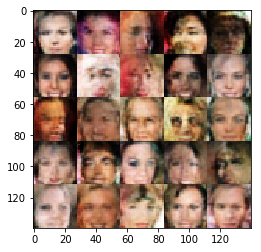

Epoch 0/1... Discriminator Loss: 0.2246... Generator Loss: 2.0724
Epoch 0/1... Discriminator Loss: 0.2458... Generator Loss: 1.9862
Epoch 0/1... Discriminator Loss: 0.1037... Generator Loss: 4.2424
Epoch 0/1... Discriminator Loss: 0.5719... Generator Loss: 1.1537
Epoch 0/1... Discriminator Loss: 0.0728... Generator Loss: 3.9850
Epoch 0/1... Discriminator Loss: 0.4426... Generator Loss: 2.1361
Epoch 0/1... Discriminator Loss: 0.5009... Generator Loss: 2.4150
Epoch 0/1... Discriminator Loss: 0.5019... Generator Loss: 1.8776
Epoch 0/1... Discriminator Loss: 0.5814... Generator Loss: 1.3871
Epoch 0/1... Discriminator Loss: 0.5226... Generator Loss: 1.4262


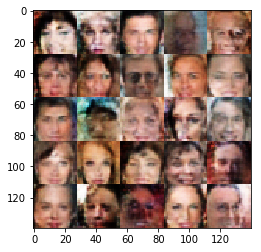

Epoch 0/1... Discriminator Loss: 2.1601... Generator Loss: 0.1784
Epoch 0/1... Discriminator Loss: 0.4806... Generator Loss: 2.8725
Epoch 0/1... Discriminator Loss: 0.5650... Generator Loss: 1.3378
Epoch 0/1... Discriminator Loss: 0.4148... Generator Loss: 2.2198
Epoch 0/1... Discriminator Loss: 0.5141... Generator Loss: 2.6015
Epoch 0/1... Discriminator Loss: 0.5134... Generator Loss: 1.3402
Epoch 0/1... Discriminator Loss: 0.9241... Generator Loss: 0.7017
Epoch 0/1... Discriminator Loss: 0.1488... Generator Loss: 3.1233
Epoch 0/1... Discriminator Loss: 0.3691... Generator Loss: 2.6212
Epoch 0/1... Discriminator Loss: 0.4419... Generator Loss: 1.5969


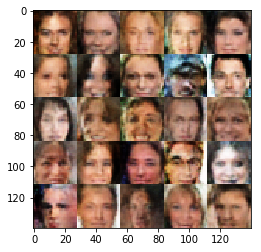

Epoch 0/1... Discriminator Loss: 1.6242... Generator Loss: 0.3639
Epoch 0/1... Discriminator Loss: 0.2701... Generator Loss: 1.9350
Epoch 0/1... Discriminator Loss: 0.3571... Generator Loss: 5.0915
Epoch 0/1... Discriminator Loss: 0.1322... Generator Loss: 3.8786
Epoch 0/1... Discriminator Loss: 0.1441... Generator Loss: 2.8424
Epoch 0/1... Discriminator Loss: 0.6259... Generator Loss: 1.0487
Epoch 0/1... Discriminator Loss: 0.4790... Generator Loss: 1.4234


In [80]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.